# Comparación de estrategias de Swing Trading: Buy&Hold VS 3MM

### Script de comparación

In [17]:
def trade_comparison(csv, equity, n_acciones, comision_fija, comision_por_accion, ref_value, p_mmr, p_mmi, p_mml,dias):
    
    
    #IMPORTACIÓN DE MÓDULOS
    
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.rc("figure", figsize=[16,9])

    
    #FUNCIONES AUXILIARES

    def MME(N,data):
        MME=N*["NaN"]
        MME.append(np.mean(data[ref_value][0:N-1]))
        x=data.shape[0]-N
        counter=N
        for i in range(x):
            MME.append(np.mean(data[ref_value][counter-N:counter]))
            counter+=1
        return MME

    def AnadirColumna(lista, nombre_lista, DataFrame):
        np.array(lista)
        NewCol=pd.DataFrame(lista, columns=[nombre_lista])
        DataFrame=pd.concat([DataFrame, NewCol], axis=1)
        return DataFrame

    
    #IMPORTACIÓN DE ARCHIVO Y PREPARACIÓN DEL MISMO

    data_original=pd.read_csv(csv)
    data=data_original
    data=data.drop(["Adj Close"], axis=1)
    data=data.dropna(axis="rows", how="any")
    data["Mean Value"]=(data["High"]+data["Low"])/2

    MME_intermedia=MME(p_mmi,data)
    MME_rapida=MME(p_mmr,data)
    MME_lenta=MME(p_mml,data)
    data=AnadirColumna(MME_rapida,"MME_rapida",data)
    data=AnadirColumna(MME_intermedia,"MME_intermedia",data)
    data=AnadirColumna(MME_lenta,"MME_lenta",data)
    data.dropna(axis=0, how="any")
    data=data[p_mml:-1]
    data.head()

    
    #GRAFICADO DE LA COTIZACIÓN Y DE LAS MEDIAS
    
    if dias == "todo":
        plt.rc("figure", figsize=[19,7])
        plt.plot(data[ref_value])
        plt.plot(data["MME_rapida"])
        plt.plot(data["MME_intermedia"])
        plt.plot(data["MME_lenta"])
        plt.legend((ref_value,"MME_rapida","MME_intermedia","MME_lenta"))
    else:
        plt.rc("figure", figsize=[19,7])
        plt.plot(data[ref_value][-dias:])
        plt.plot(data["MME_rapida"][-dias:])
        plt.plot(data["MME_intermedia"][-dias:])
        plt.plot(data["MME_lenta"][-dias:])
        plt.legend((ref_value,"MME_rapida","MME_intermedia","MME_lenta"))
    plt.show()

    
    #RESULTADOS PARA LA ESTRATEGIA BUY & HOLD

    compra=data[ref_value][p_mml] + comision_porcentual * n_acciones * data[ref_value][p_mml] #Coste de compra + comision porcentual
    venta=data[ref_value][-1:] - comision_porcentual * n_acciones * data[ref_value][-1:] #Ingreso por venta- comision porcentual
    comision=2*(comision_fija+comision_por_accion*n_acciones) #Calculo de la comision fija y variable por tranasacción
    profit=float(venta-compra-comision) 


    ebit_integro_BH=venta-compra  #Beneficio antes de comisiones si se comprase el activo entero
    rent_integra_BH=ebit_integro_BH/compra  #Rentabilidad antes de comisiones si se comprase el activo entero
    ebit_rel_BH=equity*rent_integra_BH  #Beneficio antes de comisiones teniendo en cuenta el capital empleado, o equity.
    ebitda_rel_BH=ebit_rel_BH-comision  #Beneficio tras comisiones para el capital empleado
    rent_neta_BH=ebitda_rel_BH/equity  #Rentabilidad tras comisiones para el capital empleado
    print("\n\n"+21*"*"+"\nESTRATEGIA BUY & HOLD\n"+21*"*"+"\n")
    print("Compra el %s en %.2f$\nVenta el %s en %.2f$. \nPara un capital de %d$, el beneficio es: %.2f$. Rentabilidad neta del %.2f%%\n\n" %(data["Date"][p_mml],compra,data["Date"][data.shape[0]],venta,equity,ebitda_rel_BH,rent_neta_BH*100))


    df=data
    for i in range(df.shape[0]):  #Eliminación de aquellos datos que estén bajo las medias. Son valores que indican esperar. No invertir
        if ((df["MME_lenta"][i+p_mml] or df["MME_rapida"][i+p_mml] or df["MME_intermedia"][i+p_mml]) > df[ref_value][i+p_mml]):
            df=df.drop([i+p_mml], axis=0)

    dias=df.index.tolist()
    precios=df[ref_value].tolist()
    fechas=df["Date"].tolist()

    
    #RESULTADOS PARA LA ESTRATEGIA DE IMPULSO

    print(21*"*"+"\nESTRATEGIA DE IMPULSO\n"+21*"*"+"\n")
    compras=0
    ventas=0
    n=p_mml+2
    operaciones=0
    profit_list=[]
    transaction_profit=0
    lenght=df.shape[0]
    entrada=0
    salida=0
    while n < (lenght-1): # Determinación de cuándo comprar y cuándo vender

        #  Como se elimnaron las cotizaciones situadas bajo las medias, ahora el DataSet contiene
        #  fragmentos de tiempo, donde el primer día indica compra y el último, venta.
        #  Restando el valor de compra al de venta, y teniendo en cuenta comisiones, conocemos el 
        #  beneficio de la operación, que puede ser positivo o negativo, si se produjo una falsa señal


        if dias[n] != (dias[n-1]+1):
            print("El día %s inicia una compra a %.2f" %(fechas[n], precios[n]))
            compras += (precios[n] + comision_porcentual * n_acciones * precios[n])
            operaciones += 1
            ultimo="compra"
            if operaciones==1:
                primera="compra"
                valor=precios[n]
            entrada=precios[n]
        if dias[n] != (dias[n+1]-1):
            if operaciones!=0:
                print("El día %s se cierra una venta a %.2f" %(fechas[n], precios[n]))
            ventas += (precios[n] - comision_porcentual * n_acciones * precios[n])
            operaciones += 1
            ultimo="venta"
            if operaciones==1:
                primera="venta"
                valor=precios[n]
            salida=precios[n]

            if entrada!=0:
                transaction_profit= ((salida/entrada)*equity-equity) - 2*(comision_porcentual * equity + (comision_fija+comision_por_accion*n_acciones))
                profit_list.append(transaction_profit)
        n+=1

    
    #  Graficado del beneficio obtenido en cada operación, indicando en verde o rojo si es positivo o negativo    
    plt.rc("figure", figsize=[19,7])
    pf=pd.DataFrame({ "Transaccion":list(range(1,len(profit_list)+1)),"Beneficio":profit_list})
    pf = pf.drop(pf[pf["Beneficio"]==0].index)  #Eliminación de las transacciones de beneficio 0
    pf['Beneficio'].plot(kind='bar', color=(pf['Beneficio'] > 0).map({True: 'g',False: 'r'}))
    plt.show()

    
    # Para dar resultados lógicos se realiza este ajuste:
    # Si la ultima operación fue de compra, se tendrán en cuenta los beneficios debidos a una venta hoy mismo.
    # Si la primera operación fue una venta, se anularán sus beneficios, ya que al no haber una compra, son iguales al ingreso por venta
    if ultimo=="compra":
        ventas += float(df[ref_value][-1:])
    if primera=="venta":
        ventas -=valor


    ebit_integro_IM=ventas-compras
    rent_integra_IM=ebit_integro_IM/valor
    ebit_rel_IM=equity*rent_integra_IM
    ebitda_rel_IM=ebit_rel_IM-operaciones*(comision_fija+comision_por_accion*n_acciones)
    rent_neta_IM=ebitda_rel_IM/equity
    print("Beneficio por acción: %.2f$\nBeneficio para %d$: %.2f$\nRentabilidad neta: %.2f%%" %(ebit_integro_IM,equity,ebitda_rel_IM,rent_neta_IM*100))


    
    #GRÁFICA COMPARATIVA DE RESULTADOS

    print("\n\n"+25*"*"+"\nCOMPARACIÓN DE RESULTADOS\n"+25*"*"+"\n")
    plt.rc("figure", figsize=[5,5])
    plt.bar(["Buy & Hold","Impulso"] ,[ebitda_rel_BH,ebitda_rel_IM])
    plt.xlabel("Estrategias")
    plt.ylabel("Beneficio Neto")
    plt.title("Comparación de estrategias")
    plt.show()

    

    #RESUMEN DE RESULTADOS

    print(16*"*"+"\nRESUMEN DE DATOS\n"+16*"*"+"\n")
    print("Buy&Hold: con %d$, se obtiene un beneficio de %.2f$ en 2 operaciones. Rentabilidad del %.2f%% \nImpulso: con %d$, se obtiene un beneficio de %.2f$ tras %d operaciones. Rentabilidad del %.2f%%" %(equity,ebitda_rel_BH,rent_neta_BH*100,equity,ebitda_rel_IM, operaciones, rent_neta_IM*100))
    dif=ebitda_rel_IM-ebitda_rel_BH
    print("DIFERENCIA: %.2f$" %dif)
    
    return df

### Datos de la comparación

In [20]:
###  ARCHIVO  ###
csv="BTC-EUR.csv" #Nombre del archivo que contiene los datos de la cotización según Yahoo Finance

### CAPITAL Y ACCIONES  ###
equity=100  #Capital de inversión en $ o €
n_acciones=1  #Número de acciones para operar

### COMISIONES DEL BROKER  ###
comision_fija=0  #Comisión fija en $ o € por operación
comision_por_accion=0  #Comisión fija por acción en $ o € en cada operación
comision_porcentual=0.0025  #Comisión porcentual sobre la acción. P.Ej: 0.05 sería una comisión del 5% sobre el precio de la acción

###  DATOS PARA EL ALGORITMO  ###
ref_value="Mean Value"  #Valor de referencia del algoritmo y de las medias móviles: "Mean Value", "Open", "High", "Low", "Close"
p_mmr=1  #Período de la Media Móvil Rápida
p_mmi=3  #Período de la Media Móvil Intermedia
p_mml=5  #Período de la Media Móvil Lenta
dias="todo" #Días, desde hoy hacia atrás, que se desean observar en la gráfica. Si quieres ver todo, escribe "todo"

# Resultados

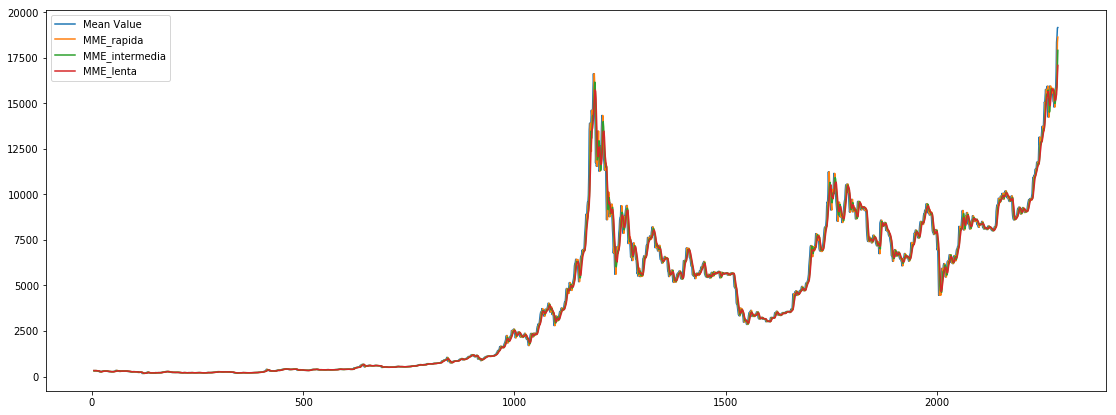



*********************
ESTRATEGIA BUY & HOLD
*********************

Compra el 2014-09-22 en 313.60$
Venta el 2020-12-16 en 19107.76$. 
Para un capital de 100$, el beneficio es: 5992.99$. Rentabilidad neta del 5992.99%


*********************
ESTRATEGIA DE IMPULSO
*********************

El día 2014-10-19 inicia una compra a 305.87
El día 2014-10-19 se cierra una venta a 305.87
El día 2014-10-22 inicia una compra a 303.36
El día 2014-10-22 se cierra una venta a 303.36
El día 2014-11-05 inicia una compra a 269.27
El día 2014-11-15 se cierra una venta a 310.09
El día 2014-11-24 inicia una compra a 303.52
El día 2014-11-27 se cierra una venta a 297.30
El día 2014-11-29 inicia una compra a 305.02
El día 2014-12-03 se cierra una venta a 306.31
El día 2014-12-06 inicia una compra a 305.00
El día 2014-12-07 se cierra una venta a 305.09
El día 2014-12-21 inicia una compra a 265.20
El día 2014-12-24 se cierra una venta a 269.15
El día 2015-01-01 inicia una compra a 262.39
El día 2015-01-02 se ci

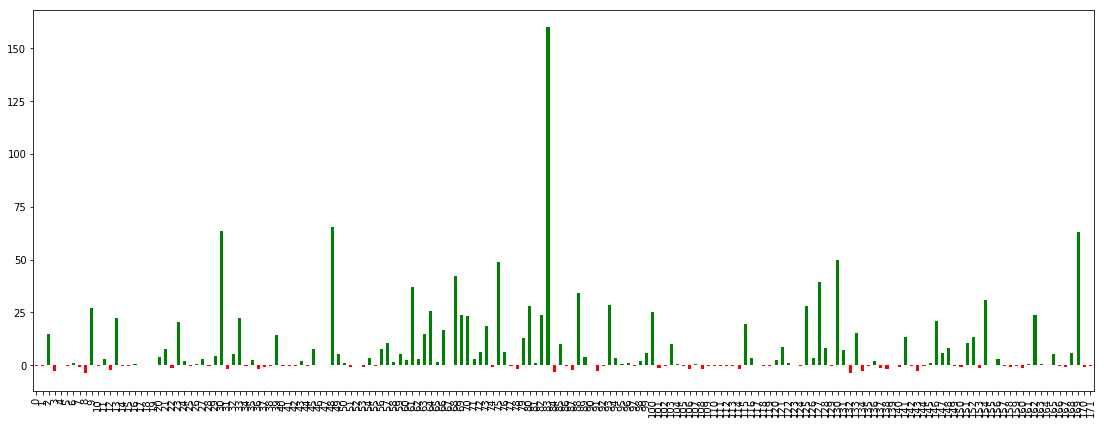

Beneficio por acción: 52399.83$
Beneficio para 100$: 17405.29$
Rentabilidad neta: 17405.29%


*************************
COMPARACIÓN DE RESULTADOS
*************************



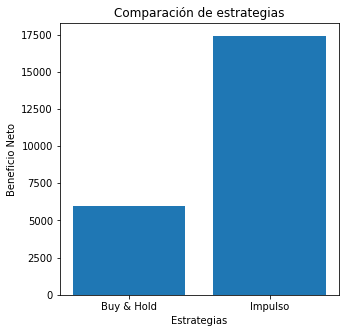

****************
RESUMEN DE DATOS
****************

Buy&Hold: con 100$, se obtiene un beneficio de 5992.99$ en 2 operaciones. Rentabilidad del 5992.99% 
Impulso: con 100$, se obtiene un beneficio de 17405.29$ tras 346 operaciones. Rentabilidad del 17405.29%
DIFERENCIA: 11412.29$


In [21]:
df_mean=trade_comparison(csv, equity, n_acciones, comision_fija, comision_por_accion, ref_value, p_mmr, p_mmi, p_mml,dias)